<h2>Image Classification with Transfer Learning in Keras</h2>

<h2>Task 1: Introduction and Importing Libraries</h2>

In [ ]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np
import pets

from matplotlib import pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

print('Tensorflow version: ', tf.__version__)
print('Is using GPU?: ', tf.test.is_gpu_available())  

Tensorflow version:  2.3.0
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is using GPU?:  True


<h2>Task 2: Oxford-IIIT Pet Dataset</h2>
<h2>Task 2: Cats vs Dogs Dataset</h2>

In [ ]:
pets.download_and_extract('data', '.')

In [ ]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('/content/data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('/content/data/annotations/test.txt')

print('Training Examples: ', count_train)
print('Test Examples: ', count_test)

Training Examples:  3680
Test Examples:  3669


In [ ]:
test_annot

{'Abyssinian_201.jpg': 'cat',
 'Abyssinian_202.jpg': 'cat',
 'Abyssinian_204.jpg': 'cat',
 'Abyssinian_205.jpg': 'cat',
 'Abyssinian_206.jpg': 'cat',
 'Abyssinian_207.jpg': 'cat',
 'Abyssinian_20.jpg': 'cat',
 'Abyssinian_210.jpg': 'cat',
 'Abyssinian_212.jpg': 'cat',
 'Abyssinian_213.jpg': 'cat',
 'Abyssinian_215.jpg': 'cat',
 'Abyssinian_216.jpg': 'cat',
 'Abyssinian_217.jpg': 'cat',
 'Abyssinian_219.jpg': 'cat',
 'Abyssinian_21.jpg': 'cat',
 'Abyssinian_220.jpg': 'cat',
 'Abyssinian_221.jpg': 'cat',
 'Abyssinian_223.jpg': 'cat',
 'Abyssinian_224.jpg': 'cat',
 'Abyssinian_225.jpg': 'cat',
 'Abyssinian_226.jpg': 'cat',
 'Abyssinian_228.jpg': 'cat',
 'Abyssinian_22.jpg': 'cat',
 'Abyssinian_230.jpg': 'cat',
 'Abyssinian_232.jpg': 'cat',
 'Abyssinian_24.jpg': 'cat',
 'Abyssinian_25.jpg': 'cat',
 'Abyssinian_26.jpg': 'cat',
 'Abyssinian_27.jpg': 'cat',
 'Abyssinian_29.jpg': 'cat',
 'Abyssinian_2.jpg': 'cat',
 'Abyssinian_30.jpg': 'cat',
 'Abyssinian_31.jpg': 'cat',
 'Abyssinian_32.jpg': 

<h2>Task 3: Get Random Batch</h2>

In [ ]:
image_dir = '/content/data/images/'

def get_random_batch(annot, batch_size = 4):
  all_keys = list(annot.keys())
  total_examples = len(all_keys)

  indices = np.random.choice(range(total_examples), batch_size, replace = False)

  x = np.zeros((batch_size, 128, 128, 3))
  y = np.zeros((batch_size, 1))

  images = []
  for i, index in enumerate(indices):
    image_path = os.path.join(image_dir, all_keys[index])
    image = tf.keras.preprocessing.image.load_img(
        image_path, target_size = (128, 128)
    )
    arr = tf.keras.preprocessing.image.img_to_array(image)
    arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
    arr = np.expand_dims(arr, axis = 0)
    x[i] = arr
    y[i] = class_to_index[annot[all_keys[index]]]
    images.append(image)

  return x, y, images

Displaying first 8 examples...


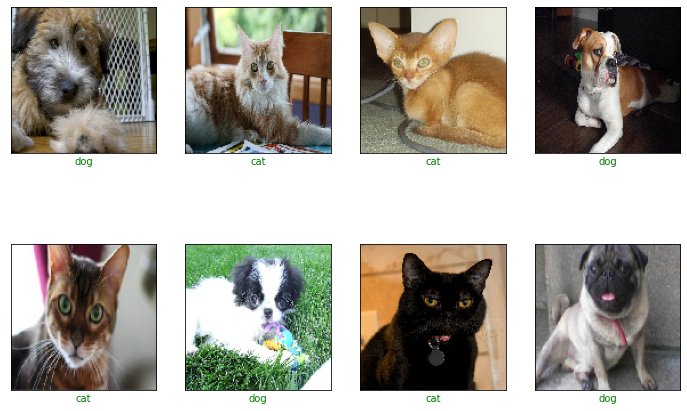

In [ ]:
x, y, images = get_random_batch(train_annot, batch_size = 8)
pets.display_examples(x, y, y, images, index_to_class).show()

<h2>Task 4: Create Model</h2>

In [ ]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
    include_top = False,
    pooling = 'avg',
    weights = 'imagenet',
    input_shape = (128, 128, 3)
)

mnet.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

In [ ]:
def create_model():
  model = tf.keras.models.Sequential([
                                      mnet,
                                      tf.keras.layers.Dropout(0.5),
                                      tf.keras.layers.Dense(1, activation = 'sigmoid')
  ])
  #model.layers[0].trainable = False
  model.compile(
      loss = 'binary_crossentropy',
      optimizer = 'adam',
      metrics = ['accuracy']
  )
  return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 1280)              2257984   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


<h2>Task 5: Model Training</h2>

In [ ]:
def data_generator(batch_size, annot):
  while True:
    x, y, _ = get_random_batch(annot, batch_size)
    yield (x,y)

In [ ]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_test/batch_size)

print('Training steps: ', steps_per_epoch)
print('Validation steps: ', validation_steps)

Training steps:  115
Validation steps:  114


In [ ]:
%%time
_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data = data_generator(batch_size, test_annot),
    steps_per_epoch = steps_per_epoch,
    validation_steps = validation_steps,
    epochs = 1
)

115/115 [==============================] - 34s 293ms/step - loss: 0.1212 - accuracy: 0.9565 - val_loss: 0.9720 - val_accuracy: 0.9172
CPU times: user 38.8 s, sys: 2.36 s, total: 41.1 s
Wall time: 33.9 s


In [ ]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)

Displaying first 8 examples...


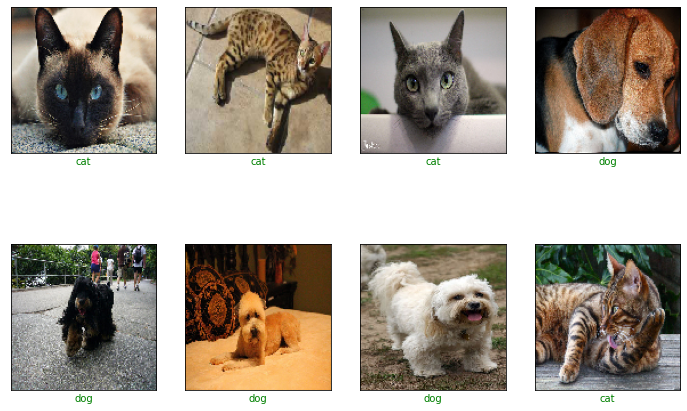

In [ ]:
pets.display_examples(x, y, preds, images, index_to_class).show()

<h2>Task 6: Predictions</h2>